# Midterm Exam (part 2) - Analysis

### Name: Rolando Sánchez

(a) Read the instructions below and clearly outline the directory structure of your module in an **analysis.ipynb** notebook. Follow the class notes on how to structure python packages.

The structure of the module `orbit.py` is the following: <br>
```
orbit/                          # Root package directory
│
├── orbit/                      # Main module package
│   ├── __init__.py             # Package initialization
│   ├── orbit.py                # Main module/script
│   └── test_orbit.py           # Unit Testing file
│
├── examples/                   # Example scripts and notebooks
│   ├── *.ini                   # Different examples of configuration files
│   ├── example_output/
│   │   ├ *.png                 # Different example plots for the orbits
|   │   ├ *.gif                 # Different example animations for the orbits
|   │   └ *.vtk                 # Different example vtk files for the orbits
│   └── basic_usage.ipynb       # Full example in interactive notebook
│
├── analysis.ipynb              # Analysis Python Notebook
├── outputfolder/
│   └*.vtk                      # Different vtk files generated for the analysis review
│
├── setup.py                    # Package installation
└── README.md                   # Project overview
```

(i) Use your module/script to run and show two simulations: one relativistic and one classical for this set of initial conditions. It may be helpful to compare the orbital history in a single plot.

| Parameter | Description                                       | Units      |
|-----------|---------------------------------------------------|------------|
| $e$       | Eccentricity of the orbit                         | $0$        |
| $M$       | Mass of the central black hole                    | $5\times 10^6\,\rm M_\odot$ |
| $a$       | Semi-major axis of the orbit                      | $1\,\rm AU$|
| $N$       | Number of orbital periods to simulate             | $2$        |
| Method    | Numerical method for ODE integration              | RK3        |

In [120]:
import orbit
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [2]:
# Let's define the parameters for the simulations
e_sim = 0.
m_sim = 5e6 
a_sim = 1
n_sim = 2
method_sim = "scipy"

# Let's define a folder to save the results
analysis_output = "./outputfolder"
# And tnames for the vtk files generated
classical_vtk = "classical_orbit"
relativistic_vtk = "relativistic_orbit"

In [3]:
# Let's create an instance of our class
simulations_tbp = orbit.TwoBodyProblem(m_sim, a_sim, e_sim)

In [4]:
sol_classical = orbit.RunIntegrator(n_sim, False, None, simulations_tbp, method_sim, analysis_output, classical_vtk, None) # Classical orbit
sol_relativistic = orbit.RunIntegrator(n_sim, True, None, simulations_tbp, method_sim, analysis_output, relativistic_vtk, None) # Relativistic orbit

# Run
s_c, t_c = sol_classical.run()
s_r, t_r = sol_relativistic.run()

# Get Swarzchild radius from vtk files, please modify this if the output directory with the generated vtk files is different. 
r_s =  pv.read(f"{analysis_output}/relativistic_orbit.vtk").field_data['schwarzschild_radius'][0]

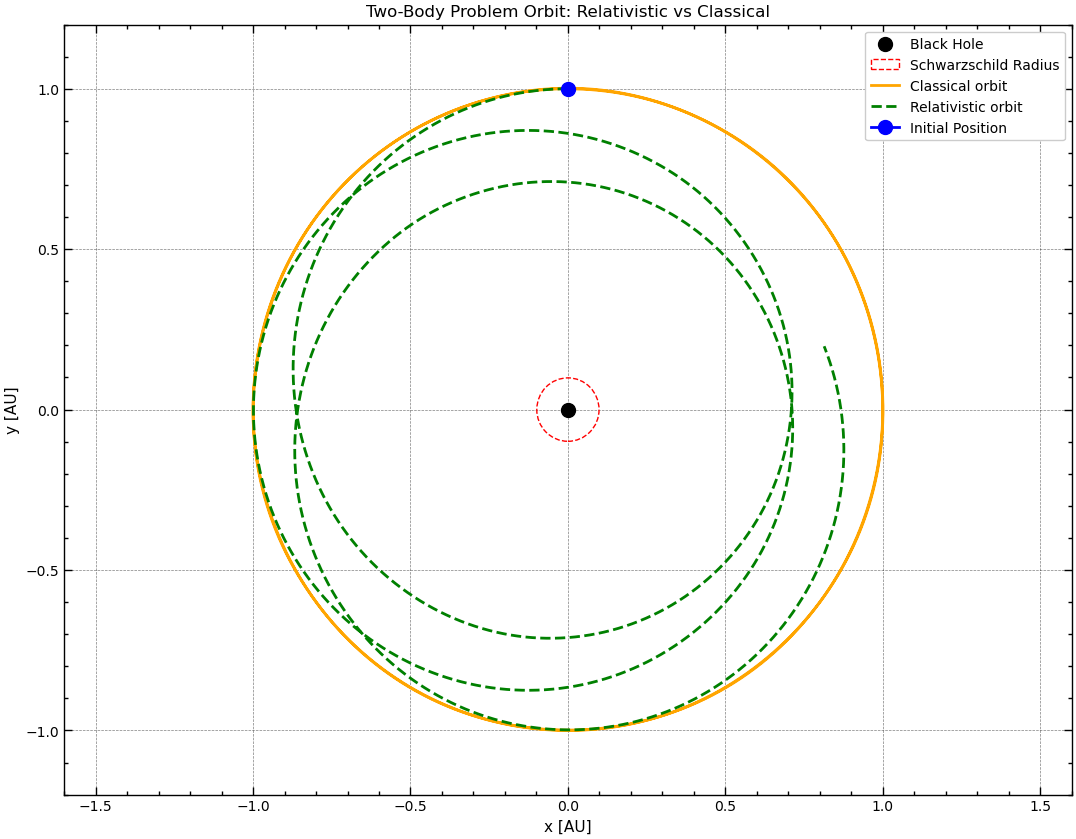

In [5]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Relativistic vs Classical")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.plot(s_c[:,0,0], s_c[:,0,1], color = "orange", label = "Classical orbit")
ax.plot(s_r[:,0,0], s_r[:,0,1], color = "green", label = "Relativistic orbit", linestyle = "--")
ax.plot(s_c[0,0,0], s_c[0,0,1], color = "blue", label = "Initial Position", marker = ".", markersize = 20)
ax.legend()
plt.show()
plt.close()

(j) Use the orbital history of both simulations to design a method that quantifies their differences and evaluates the importance of using the relativistic approach for massive objects. Do we need to worry about the relativistic corrections if we replace the black hole with our Sun?

To quantify the differences we can use the Root Mean Square Deviation between the two trajectories.<br>
Where $RMSD \rightarrow 0$ tells us that both relativistic and classical orbits overlap almost everywhere, suggesting that the relativistic effects are negligible. On the other hand, $RMSD >> 0$ indicates that both trajectories diverge significantly, suggesting that relativistic effects must be considered.  
$$RMSD = \sqrt{\frac{1}{N}\sum^N_i (\vec{r}_{relativistic} - \vec{r}_{classical})^2}$$

In [23]:
def rmsd(t_class, r_class, t_rel, r_rel):
    """
    Quantifies differences between classical and relativistic orbits using Root Mean Square Deviation.
    
    Input:
        t_class (np.array of floats) -> Array containing the time axis for the classical solution (shape [N])
        r_class (np.array of float-containing arrays) -> Classical solution array [rx, ry] (shape [N, 2])
        t_rel (np.array of floats) -> Array containing the time axis for the relativistic solution (shape [N])
        r_rel (np.array of float-containing arrays) -> Relativistic solution array [rx, ry]  (shape [N,2])
    Output:
        rmsd_value (float) -> RMSD value characterizing the difference between the orbits.
    """
    # Interpolate to common time grid
    # Create common time grid
    t_min = max(t_class.min(), t_rel.min())
    t_max = min(t_class.max(), t_rel.max())
    t_common = np.linspace(t_min, t_max, min(len(t_class), len(t_rel)))

    # Interpolate both trajectories to common time grid
    interp_class = interp1d(t_class, r_class, axis=0, kind='linear', bounds_error=False, fill_value=np.nan)
    interp_rel = interp1d(t_rel, r_rel, axis=0, kind='linear', bounds_error=False, fill_value=np.nan)
    
    r_class_interp = interp_class(t_common)
    r_rel_interp = interp_rel(t_common)
    
    # Calculate RMSD (Euclidean distance in 2D)
    squared_diff = np.sum((r_class_interp - r_rel_interp)**2, axis=1)
    rmsd_value = np.sqrt(np.mean(squared_diff))
    
    return rmsd_value

In [29]:
# Using our previously obtained solutions for the relativistic and classical approaches
rmsd_sim0 = rmsd(t_c, s_c[:,0], t_r, s_r[:,0])
print(f"The RMSD value for this case is: {rmsd_sim0:.3f} [AU]" )

The RMSD value for this case is: 1.405 [AU]


As our characteristic $RMSD=1.405 [AU]$, we conclude that there are significant difference between classical and relativistic orbits for this case, therefore, relativistic corrections **must** been considered.

Now, for the case where we replace the black hole with our sun, we don't need to worry about relativistic effects as demonstrated by using out previously defined method. Where the $RMSD = 0 [AU]$.<br>
Physically, this is expected as the distance between the planet and the sun is huge ($1 [AU]$) and the Schwarzschild radius of the Sun is around 3 km, or roughly 0 [AU].

In [58]:
# Let's create an instance of our class with the mass of our sun, i.e, 1 [Solar Masses]
simulation_suncase = orbit.TwoBodyProblem(1, a_sim, e_sim)
sol_classical_suncase = orbit.RunIntegrator(n_sim, False, None, simulation_suncase, method_sim, analysis_output, "sun_classical_vtk", None) # Classical orbit
sol_relativistic_suncase = orbit.RunIntegrator(n_sim, True, None, simulation_suncase, method_sim, analysis_output, "sun_relativistic_vtk", None) # Relativistic orbit

# Run
s_c_sun, t_c_sun = sol_classical_suncase.run()
s_r_sun, t_r_sun = sol_relativistic_suncase.run()

# Get Swarzchild radius from vtk files, please modify this if the output directory with the generated vtk files is different. 
r_s_sun =  pv.read(f"{analysis_output}/sun_relativistic_vtk.vtk").field_data['schwarzschild_radius'][0]

# Using our previously obtained solutions for the relativistic and classical approaches
rmsd_sim_sun = rmsd(t_c_sun, s_c_sun[:,0], t_r_sun, s_r_sun[:,0])
print(f"The RMSD value replacing the Black Hole with our sun is: {rmsd_sim_sun:.3f} [AU]" )

The RMSD value replacing the Black Hole with our sun is: 0.000 [AU]


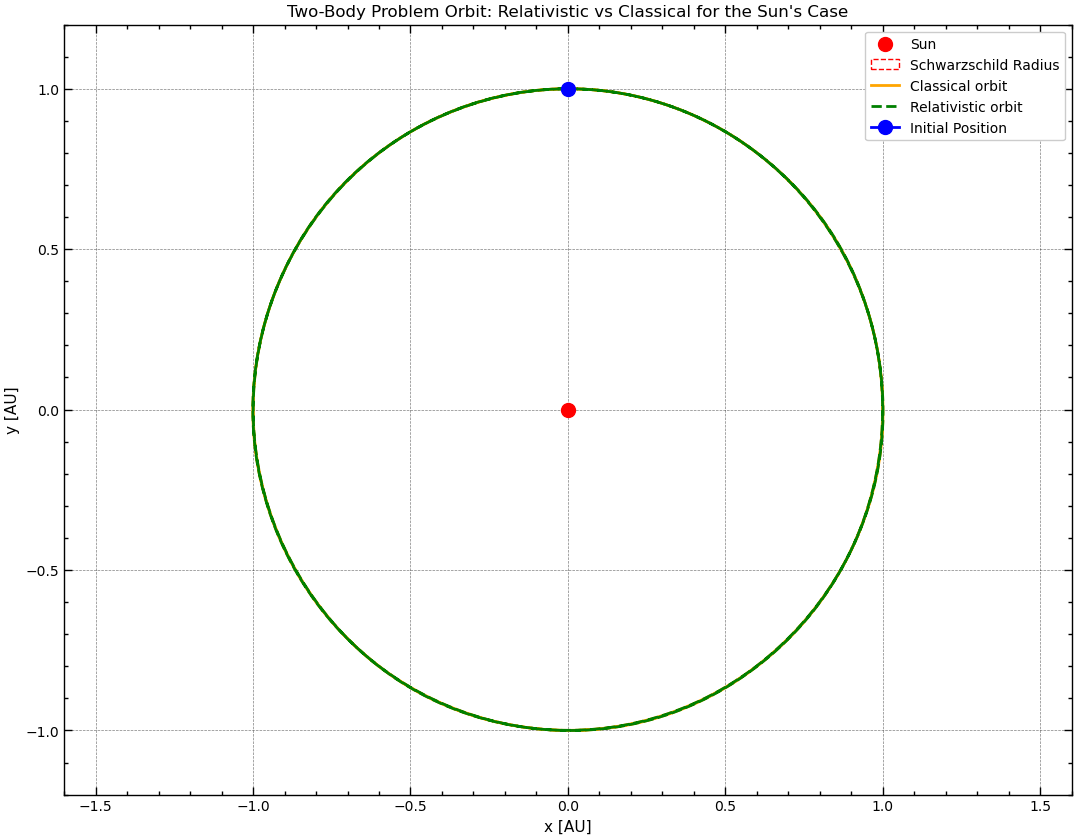

In [62]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Relativistic vs Classical for the Sun's Case")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='red', s=100, label="Sun")
schwarzschild_circle_sun = plt.Circle((0, 0), r_s_sun, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle_sun)
# Plot initial position of planet
ax.plot(s_c_sun[:,0,0], s_c_sun[:,0,1], color = "orange", label = "Classical orbit")
ax.plot(s_r_sun[:,0,0], s_r_sun[:,0,1], color = "green", label = "Relativistic orbit", linestyle = "--")
ax.plot(s_c_sun[0,0,0], s_c_sun[0,0,1], color = "blue", label = "Initial Position", marker = ".", markersize = 20)
ax.legend()
plt.show()
plt.close()


### The role of eccentricity (3 points):

(k) Use your module/script to run and show three relativistic simulations for objects with different eccentricities, $e$, and assuming the same $M$, $a$, $N$ as above. It may be helpful to compare the orbital history for all values of $e$ in a single plot throughout time.

| Object           | Eccentricity ($e$) | Integration Method |
|------------------|--------------------|--------------------|
| Earth            | 0.01671            | Trapezoidal        |
| Pluto            | 0.25               | Trapezoidal        |
| 7092 Cadmus      | 0.70               | Trapezoidal        |

In [63]:
# Let's create an instance of our class with the different eccentricities
e_earth = 0.01671
rel_sim_earth = orbit.TwoBodyProblem(m_sim, a_sim, e_earth)
e_pluto = 0.25
rel_sim_pluto = orbit.TwoBodyProblem(m_sim, a_sim, e_pluto)
e_cadmus = 0.70
rel_sim_cadmus = orbit.TwoBodyProblem(m_sim, a_sim, e_cadmus)

In [64]:
sol_earth = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "trapezoidal", analysis_output, "orbit_earth", None) # Earth's orbit
sol_pluto = orbit.RunIntegrator(n_sim, True, None, rel_sim_pluto, "trapezoidal", analysis_output, "orbit_pluto", None) # Pluto's orbit
sol_cadmus = orbit.RunIntegrator(n_sim, True, None, rel_sim_cadmus, "trapezoidal", analysis_output, "orbit_cadmus", None) # Cadmus's orbit
# Run
s_earth, t_earth = sol_earth.run()
s_pluto, t_pluto = sol_pluto.run()
s_cadmus, t_cadmus = sol_cadmus.run()

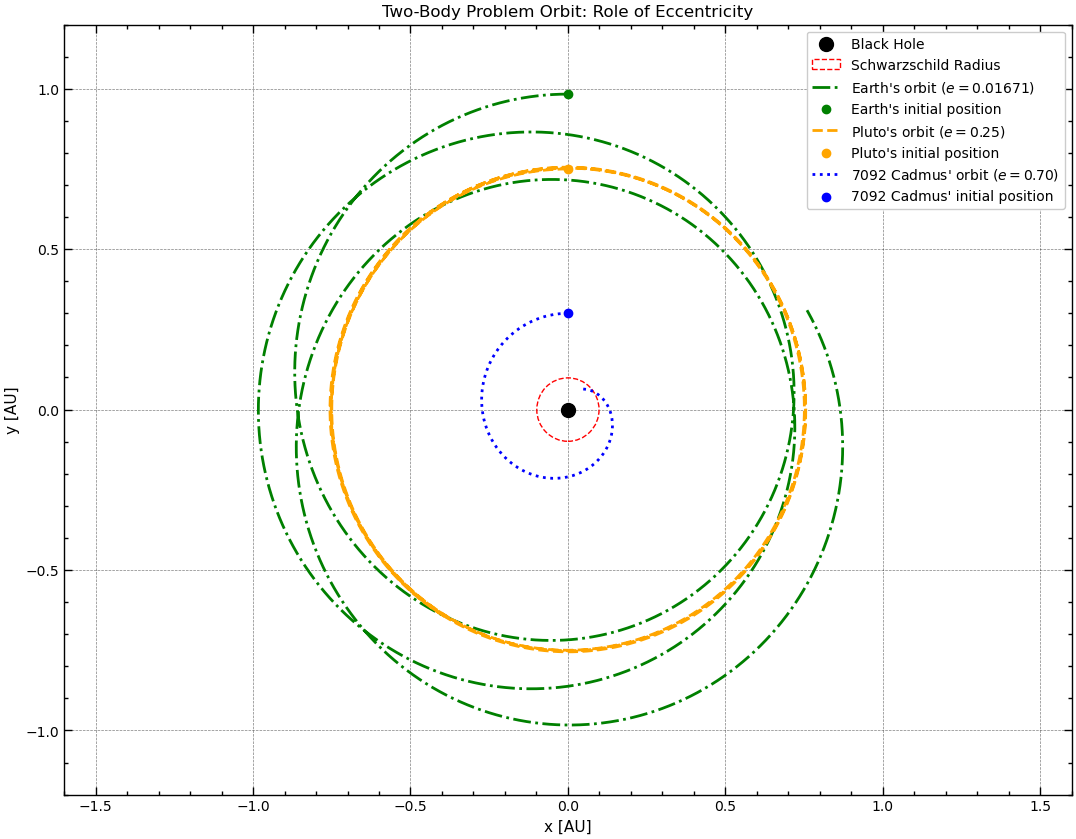

In [65]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Role of Eccentricity")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.plot(s_earth[:,0,0], s_earth[:,0,1], color = "green", label = r"Earth's orbit ($e = 0.01671$)", linestyle = "-.")
ax.scatter(s_earth[0,0,0], s_earth[0,0,1], color = "green", label = "Earth's initial position")

ax.plot(s_pluto[:,0,0], s_pluto[:,0,1], color = "orange", label = r"Pluto's orbit ($e = 0.25$)", linestyle = "--")
ax.scatter(s_pluto[0,0,0], s_pluto[0,0,1], color = "orange", label = "Pluto's initial position")

ax.plot(s_cadmus[:,0,0], s_cadmus[:,0,1], color = "blue", label = r"7092 Cadmus' orbit ($e = 0.70$)", linestyle = ":")
ax.scatter(s_cadmus[0,0,0], s_cadmus[0,0,1], color = "blue", label = "7092 Cadmus' initial position")

ax.legend()
plt.show()
plt.close()

(l) Describe the differences in the orbits of the above objects. What happens to objects with high eccentricities?

We can observe that Earth's orbit shows precession, yet it remains stable, continuously orbiting the black hole. Pluto's orbit, despite being set with a higher eccentricity than Earth’s, appears almost circular, resembling the classical (Newtonian) result. However, this similarity is misleading since we are considering relativistic corrections.

On the other hand, 7092 Cadmus inevitably falls into the black hole, as its orbit brings it too close to the Schwarzschild radius, crossing the event horizon, from which no return is possible.

It is important to note that, while eccentricity typically describes how much an orbit deviates from a perfect circle, in this relativistic scenario, it also characterizes how close the perihelion lies to the black hole. This is because the initial conditions, such as velocity and position, are strongly influenced by the eccentricity. Thus, eccentricity not only shapes the orbit but also determines how deep the planet "dives" into the gravitational well of the black hole.

### Numerical convergence (3 points):

(m) Use your script to generate additional simulations with the same initial conditions as before, but only for $e=0.01671$ (Earth's eccentricity) with RK3, the Trapezoidal method and the higher-order SciPy integrator. Compare the orbital history for all methods in a single plot throughout time.

In [68]:
sol_trpz = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "trapezoidal", analysis_output, "orbit_trapezoidal", None) # Trapezoidal method's orbit
sol_rk3 = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "RK3", analysis_output, "orbit_rk3", None) # Rk3 method's orbit
sol_scipy = orbit.RunIntegrator(n_sim, True, None, rel_sim_earth, "scipy", analysis_output, "orbit_scipy", None) # Scipy (DOP853) method's orbit
# Run
s_trpz, t_trpz = sol_trpz.run()
s_rk3, t_rk3 = sol_rk3.run()
s_scipy, t_scipy = sol_scipy.run()

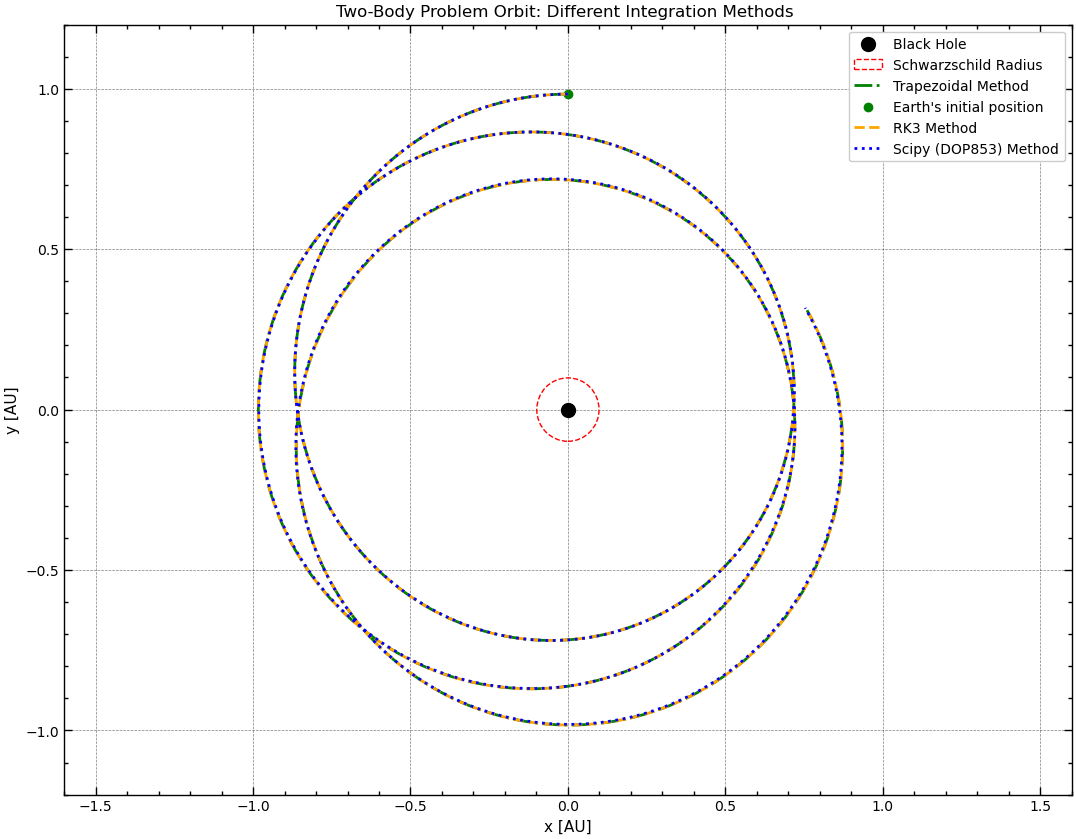

In [69]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-1.6 * a_sim * np.sqrt(1 - e_sim**2), 1.6 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Different Integration Methods ")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.plot(s_trpz[:,0,0], s_trpz[:,0,1], color = "green", label = "Trapezoidal Method", linestyle = "-.")
ax.scatter(s_earth[0,0,0], s_trpz[0,0,1], color = "green", label = "Earth's initial position")

ax.plot(s_rk3[:,0,0], s_rk3[:,0,1], color = "orange", label = "RK3 Method", linestyle = "--")

ax.plot(s_scipy[:,0,0], s_scipy[:,0,1], color = "blue", label = "Scipy (DOP853) Method", linestyle = ":")

ax.legend()
plt.show()
plt.close()

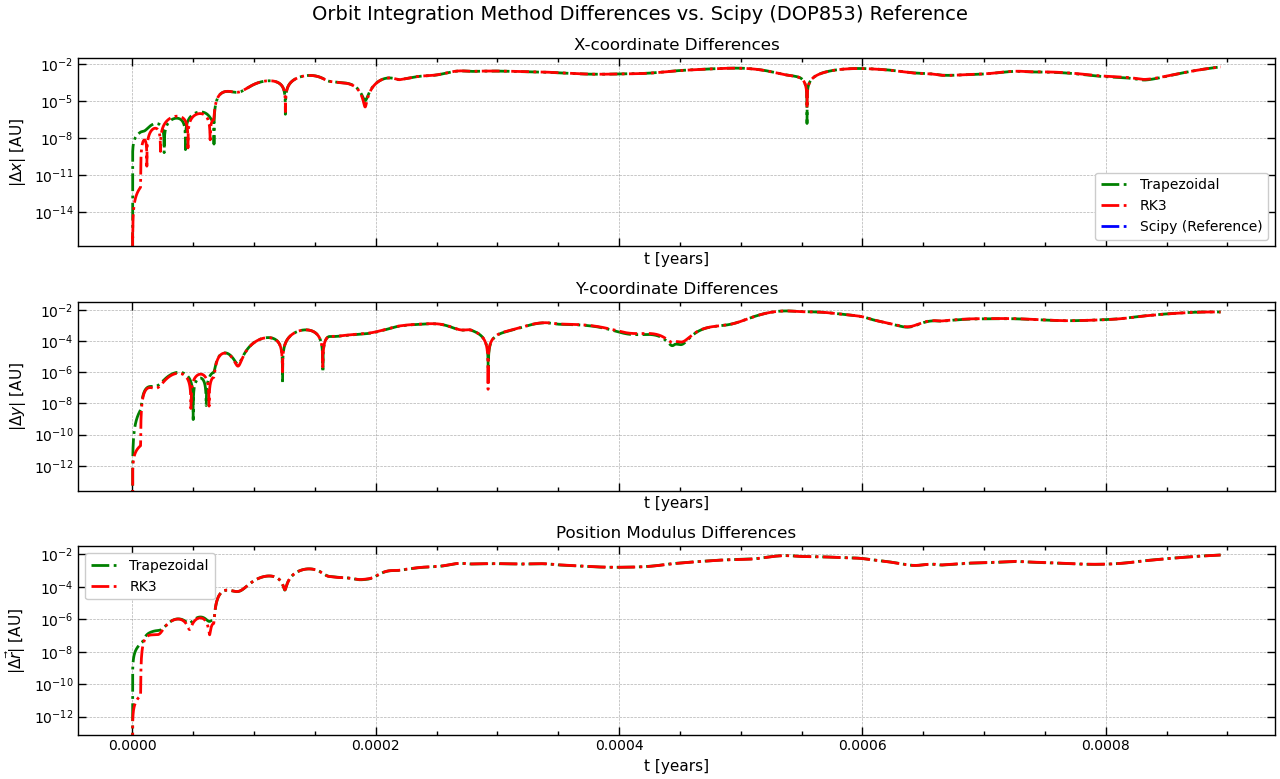

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 8), sharex=True)
fig.suptitle("Orbit Integration Method Differences vs. Scipy (DOP853) Reference", fontsize=14)

ax1.set_xlabel("t [years]")
ax1.set_ylabel(r"$|\Delta x|$ [AU]")
ax1.set_title("X-coordinate Differences")
ax1.semilogy(t_trpz, np.abs(s_trpz[:,0,0]-s_scipy[:,0,0]), color="green", label="Trapezoidal", linestyle="-.")
ax1.semilogy(t_rk3, np.abs(s_rk3[:,0,0]-s_scipy[:,0,0]), color="red", label="RK3", linestyle="-.")
ax1.semilogy(t_trpz, np.abs(s_scipy[:,0,0]-s_scipy[:,0,0]), color="blue", label="Scipy (Reference)", linestyle="-.")
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.set_xlabel("t [years]")
ax2.set_ylabel(r"$|\Delta y|$ [AU]")
ax2.set_title("Y-coordinate Differences")
ax2.semilogy(t_trpz, np.abs(s_trpz[:,0,1]-s_scipy[:,0,1]), color="green", linestyle="-.")
ax2.semilogy(t_rk3, np.abs(s_rk3[:,0,1]-s_scipy[:,0,1]), color="red", linestyle="-.")
ax2.semilogy(t_trpz, np.abs(s_scipy[:,0,1]-s_scipy[:,0,1]), color="blue", linestyle="-.")
ax2.grid(True, alpha=0.3)

ax3.set_xlabel("t [years]")
ax3.set_ylabel(r"$|\Delta \vec{r}|$ [AU]")
ax3.set_title("Position Modulus Differences")
ax3.semilogy(t_trpz, np.linalg.norm((s_trpz[:,0]-s_scipy[:,0]), axis = 1), color="green", label="Trapezoidal", linestyle="-.")
ax3.semilogy(t_rk3, np.linalg.norm((s_rk3[:,0] - s_scipy[:,0]), axis = 1), color="red", label="RK3", linestyle="-.")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In this case the difference is not significant considering the values obtained, showing numerical convergence.

(n) Measure convergence of the simulations with RK3 and Trapezoidal method for $e=0.01671$ by integrating at a number of different time steps. To analyse convergence, you need to define some measure for the error with respect to the higher order method, and then plot it against different time steps for both methods. Thus, you may add additional functions for this to your code in **orbits.py**. 

**Note:** Please include all your simulation outputs in the **outputfolder** for a reference.

In [115]:
# Define solutions for different dt steps, we have defined them in this specific range as outside of this interval
# the solutions would diverge, overcoming the hard stopping flag in our code.

dt_array = [3*1e-6, 4*1e-6, 5*1e-6, 6*1e-6, 7*1e-6, 8*1e-6, 9*1e-6, 1e-5]
ss_trpz = []
ts_trpz = []
ss_rk3 = []
ts_rk3 = []
# The integrators
for i in dt_array:
    sol_trpz_dti = orbit.RunIntegrator(n_sim, True, i, rel_sim_earth, "trapezoidal", analysis_output, f"orbit_trapezoidal_{i}", None) # Trapezoidal method's orbit
    s_trpzi, t_trpzi = sol_trpz_dti.run()
    ss_trpz.append(s_trpzi)
    ts_trpz.append(t_trpzi)

    sol_rk3_dti = orbit.RunIntegrator(n_sim, True, i, rel_sim_earth, "RK3", analysis_output, f"orbit_rk3_{i}", None) # Rk3 method's orbit
    s_rk3i, t_rk3i = sol_rk3_dti.run()
    ss_rk3.append(s_rk3i)
    ts_rk3.append(t_rk3i)

Let's see a figure with the solutions for different time steps, just to check the broadening in the solutions.

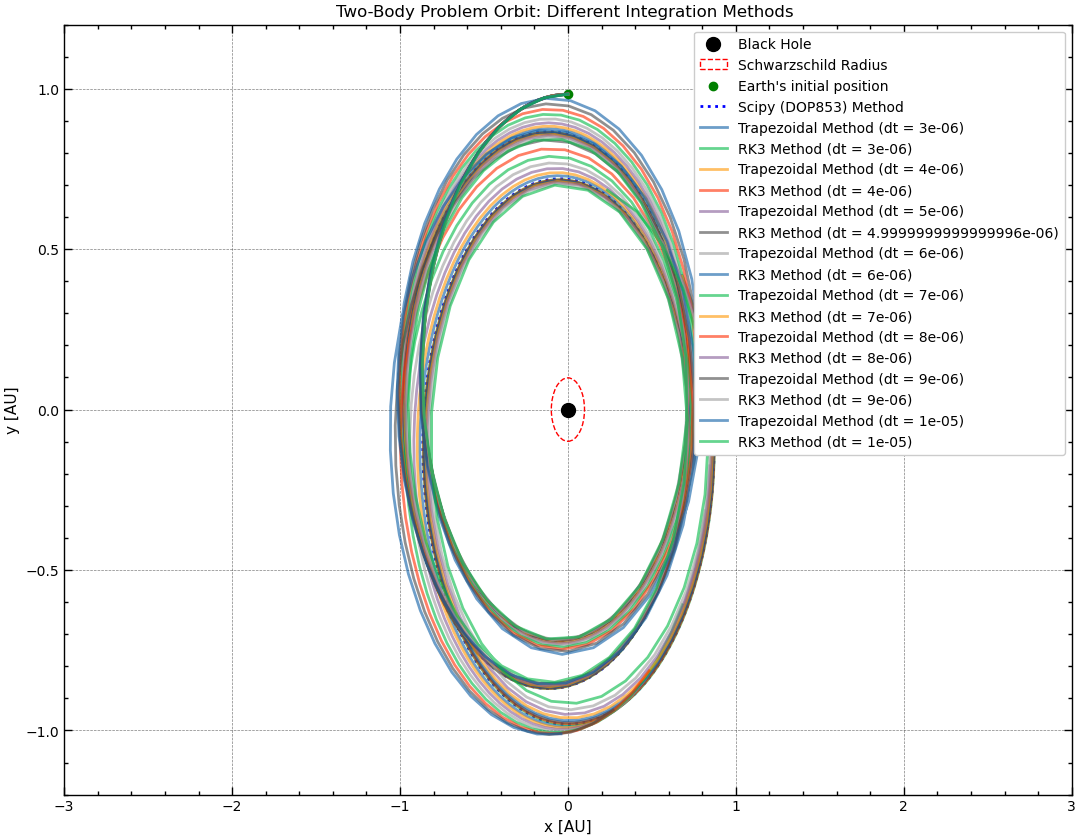

In [116]:
# Create plot
fig, ax = plt.subplots(figsize=(13,10))
ax.set_xlim(-3* a_sim * np.sqrt(1 - e_sim**2), 3 * a_sim * np.sqrt(1 - e_sim**2))
ax.set_ylim(-1.2 * a_sim * (1 + e_sim), 1.2 * a_sim * (1 - e_sim))
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Two-Body Problem Orbit: Different Integration Methods ")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), r_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of planet
ax.scatter(s_earth[0,0,0], s_trpz[0,0,1], color = "green", label = "Earth's initial position")
ax.plot(s_scipy[:,0,0], s_scipy[:,0,1], color = "blue", label = "Scipy (DOP853) Method", linestyle = ":")

for i in range(len(ts_trpz)):
    ax.plot(ss_trpz[i][:,0,0], ss_trpz[i][:,0,1], label = f"Trapezoidal Method (dt = {dt_array[i]:.0e})", alpha = 0.6)
    ax.plot(ss_rk3[i][:,0,0], ss_rk3[i][:,0,1], label = f"RK3 Method (dt = {dt_array[i]})", alpha = 0.6)

ax.legend()
plt.show()
plt.close()

And using the L2 error norm with respect to the scipy solution, we obtain the following figure that shows our expected behaviour, where the Trapezoidal error is a second order accurate method $O(h^2)$ and RK3 method is a third order accurate method $O(h^3)$.

In [124]:
# Function to compute position L2 error norm
def compute_position_error(reference, target):
    error = np.linalg.norm(reference - target, axis=1)
    return np.sqrt(np.mean(error**2))  # L2 norm over time

# Extract reference positions
x_ref = s_scipy[:, 0, 0]
y_ref = s_scipy[:, 0, 1]

# Create interpolation functions to compare the others solution with different shapes
interp_x = interp1d(t_scipy, x_ref, kind='cubic', fill_value="extrapolate")
interp_y = interp1d(t_scipy, y_ref, kind='cubic', fill_value="extrapolate")

errors_rk3 = []
errors_trpz = []

for i in range(len(dt_array)):
    # RK3
    t_rk = ts_rk3[i]
    rk3_pos = ss_rk3[i][:, 0, :]
    rk3_interp_ref = np.vstack((interp_x(t_rk), interp_y(t_rk))).T
    err_rk3 = compute_position_error(rk3_interp_ref, rk3_pos)
    errors_rk3.append(err_rk3)

    # Trapezoidal
    t_tpz = ts_trpz[i]
    tpz_pos = ss_trpz[i][:, 0, :]
    tpz_interp_ref = np.vstack((interp_x(t_tpz), interp_y(t_tpz))).T
    err_tpz = compute_position_error(tpz_interp_ref, tpz_pos)
    errors_trpz.append(err_tpz)

# Convert to numpy arrays
dt_array = np.array(dt_array)
errors_rk3 = np.array(errors_rk3)
errors_trpz = np.array(errors_trpz)

In [125]:
# Let's do a simple and quick linear regression to check for the slopes (and order of the methods)
slope_rk3, _, _, _, _ = linregress(np.log(dt_array), np.log(errors_rk3))
slope_trpz, _, _, _, _ = linregress(np.log(dt_array), np.log(errors_trpz))

print(f"Estimated order of RK3: {slope_rk3:.2f}")
print(f"Estimated order of Trapezoidal: {slope_trpz:.2f}")

Estimated order of RK3: 3.18
Estimated order of Trapezoidal: 1.97


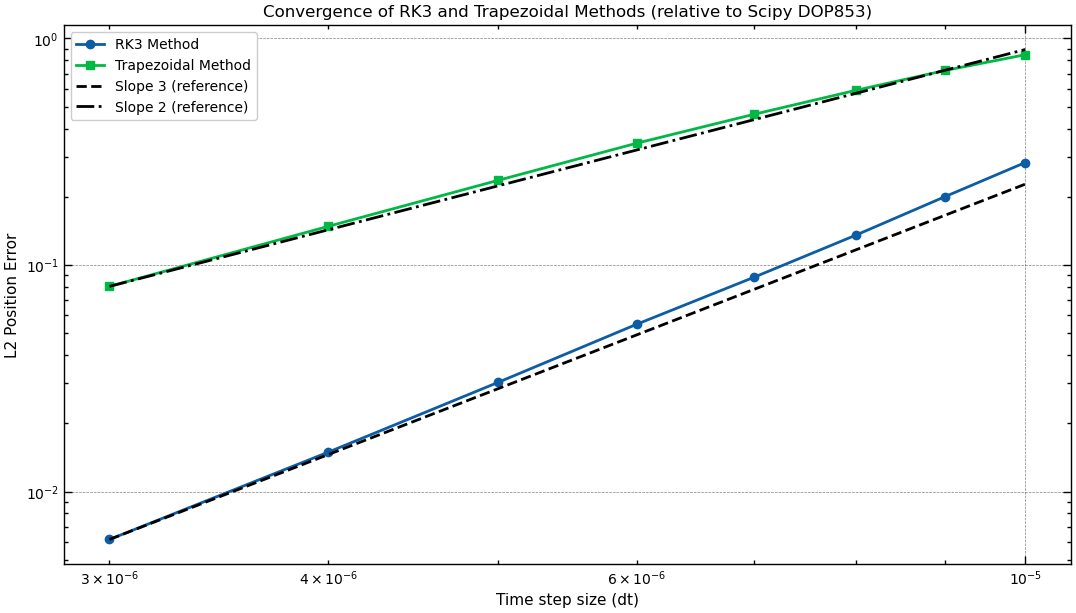

In [126]:
plt.figure(figsize=(13,7))
plt.loglog(dt_array, errors_rk3, 'o-', label='RK3 Method')
plt.loglog(dt_array, errors_trpz, 's-', label='Trapezoidal Method')

plt.loglog(dt_array, dt_array**3 * errors_rk3[0]/(dt_array[0]**3), 'k--', label='Slope 3 (reference)')
plt.loglog(dt_array, dt_array**2 * errors_trpz[0]/(dt_array[0]**2), 'k-.', label='Slope 2 (reference)')

plt.xlabel("Time step size (dt)")
plt.ylabel("L2 Position Error")
plt.title("Convergence of RK3 and Trapezoidal Methods (relative to Scipy DOP853)")
plt.legend()
plt.show()
plt.close()

### Exam submission:

- Send your code **in a single .tar ball file via email** to wbanda@yachaytech.edu.ec by the deadline.